<a href="https://colab.research.google.com/github/d-atallah/implicit_gender_bias/blob/main/08_Supervised_Sensitivity_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, Download, & Variable Statements

In [2]:
# Import & download statements
# General Statements
#!git clone https://github.com/d-atallah/implicit_gender_bias.git
#! pip install joblib
#! pip install shap
import pandas as pd
import string
import re
import joblib
#from implicit_gender_bias import config as cf
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import nltk
import sklearn
import spacy
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection & Model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD,PCA, NMF
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, log_loss, make_scorer, average_precision_score

# Model options
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Read Inputs

In [4]:
# Variables
folder_path = '/content/drive/MyDrive/Supervised Learning Notebooks/'#'/home/gibsonce/datallah-jaymefis-gibsonce/'

# Load DataFrames from pkl files

X_train = pd.read_pickle(folder_path + 'X_train_preprocessed.pkl')
X_test = pd.read_pickle(folder_path + 'X_test_preprocessed.pkl')
y_train = pd.read_pickle(folder_path + 'y_train.pkl')
y_test = pd.read_pickle(folder_path + 'y_test.pkl')

## Define Functions


In [5]:
def tokenize_and_categorize(text):
    # Tokenize and process the text using spaCy
    doc = nlp(text)
    word_features = ' '.join([token.text for token in doc])
    pos_tags = ' '.join([token.pos_ for token in doc])

    return word_features, pos_tags

In [6]:
def model_eval(pipeline, X_test, y_test):
    """
    Evaluates a specified model using accuracy, precision, recall, F-1 score, AUC-ROC & PR, log-Loss, and a confusion matrix.

    Parameters:
    - pipeline (object): Fitted pipeline.
    - X_test (list or array): Test set features.
    - y_test (list or array): True labels.

    Returns:
    - metrics_df (pd.DataFrame): DataFrame containing the metrics and scores.
    - confusion_df (pd.DataFrame): DataFrame containing a confusion matrix.
    """

    start_time = time.time()

    # Cross-validation
    scoring = {
        'f1': make_scorer(f1_score),
        'pr_auc': make_scorer(average_precision_score),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(pipeline, X_test, y_test, cv=cv, scoring=scoring)

    # Create DataFrame to store cross-validation results
    cv_metrics_df = pd.DataFrame({
    'Metric': ['F1-Score','AUC-PR'],
    'CV_Mean': [np.mean(cv_results['test_f1']),
                np.mean(cv_results['test_pr_auc']),
                ],
    'CV_Std Dev': [np.std(cv_results['test_f1']),
                   np.std(cv_results['test_pr_auc']),
                  ]
    })

    #print("\nCross Validation:")
    #print(cv_metrics_df)

    return cv_metrics_df

In [7]:
def model_testing(X_train, y_train, X_test, y_test, params):
    """
    Runs a specified model and dimensionality reduction method with tuned hyperparameters

    Parameters:
    - X_train (array-like): Training set features, preprocessed.
    - y_train (array-like): Training set labels.
    - X_test (array-like): Test set features, preprocessed.
    - y_test (array-like): Test set labels.

    Returns:
    - Pipeline: Trained and fit pipeline with the best hyperparameters.
    - X_train_ (array-like): Preprocessed  and vectorized training set features.
    - X_test_ (array-like): Preprocessed  and vectorized test set features.
    """
    """X_train_word_features, X_train_pos_tags = zip(*map(tokenize_and_categorize, X_train))
    X_test_word_features, X_test_pos_tags = zip(*map(tokenize_and_categorize, X_test))

    # Vectorize the word features
    word_features_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
    X_train_word_features_ = word_features_vectorizer.fit_transform(X_train_word_features)
    X_test_word_features_ = word_features_vectorizer.transform(X_test_word_features)

    # Vectorize the parts of speech tags
    pos_tags_vectorizer = TfidfVectorizer(ngram_range=(1, 1))
    X_train_pos_tags_ = pos_tags_vectorizer.fit_transform(X_train_pos_tags)
    X_test_pos_tags_ = pos_tags_vectorizer.transform(X_test_pos_tags)


    # Combine the vectorized word features and parts of speech tags
    X_train_combined = scipy.sparse.hstack([X_train_word_features_, X_train_pos_tags_])
    X_test_combined = scipy.sparse.hstack([X_test_word_features_, X_test_pos_tags_])"""

    vect = CountVectorizer(ngram_range=(1, 1))
    X_train_ = vect.fit_transform(X_train)
    X_test_ = vect.transform(X_test)

    model = XGBClassifier(random_state=42, **params.get('xgbclassifier', {}))
    model.fit(X_train_, y_train)

    metrics_df = model_eval(model, X_test_, y_test)
    metrics_df['params'] = params

    #joblib.dump(ablation_results, f'{folder_path}_ablation_results.pkl')

    return metrics_df


## XGBoost

### Remove nulls from preprocessing

In [8]:
non_nan_indices_train = ~X_train.isnull()
non_nan_indices_test = ~X_test.isnull()

# Filter y_train and y_test using the non-NaN indices
y_train = y_train[non_nan_indices_train]
y_test = y_test[non_nan_indices_test]

# Filter X_train and X_test to remove NaN records
X_train = X_train[non_nan_indices_train]
X_test = X_test[non_nan_indices_test]

### Sensitivity Testing

In [9]:
# Define hyperparameter values to test
subsample_values = [0.6, 0.7, 0.8, 0.9]
n_estimators_values = [100, 150, 200]
max_depth_values = [7, 9, 11]
learning_rate_values = [0.01, 0.05, 0.1, 0.2]
colsample_bytree_values = [0.4, 0.5, 0.6]

# Original params
params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.5},
}

In [32]:
sensitivity_df = pd.DataFrame(columns=['id','param','value', 'cv_mean', 'cv_std'])
data_to_concat = []

In [33]:
for test in subsample_values:
  params = {
  'xgbclassifier': {'subsample': test, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.5},
  }

  id = f'subsample: {test}'
  print(id)
  param = 'subsample'
  val = str(test)

  metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
  data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))



subsample: 0.6
subsample: 0.7
subsample: 0.8
subsample: 0.9


In [34]:
for test in n_estimators_values:
  params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': test, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.5},
  }

  id = f'n_estimators: {test}'
  print(id)
  param = 'n_estimators'
  val = str(test)

  metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
  data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))



n_estimators: 100
n_estimators: 150
n_estimators: 200


In [35]:
for test in max_depth_values:
  params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': 150, 'max_depth': test, 'learning_rate': 0.05, 'colsample_bytree': 0.5},
  }

  id = f'max_depth: {test}'
  print(id)
  param = 'max_depth'
  val = str(test)

  metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
  data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))



max_depth: 7
max_depth: 9
max_depth: 11


In [36]:
for test in learning_rate_values:
  params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': test, 'colsample_bytree': 0.5},
  }

  id = f'learning_rate: {test}'
  print(id)
  param = 'learning_rate'
  val = str(test)

  metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
  data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))

learning_rate: 0.01
learning_rate: 0.05
learning_rate: 0.1
learning_rate: 0.2


In [37]:
for test in colsample_bytree_values:
  params = {
    'xgbclassifier': {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': test},
  }

  id = f'colsample_bytree: {test}'
  print(id)
  param = 'colsample_bytree'
  val = str(test)

  metrics_df = model_testing(X_train, y_train, X_test, y_test, params)
  data_to_concat.append(pd.DataFrame({'id': [id] * len(metrics_df),
                                      'param': [param] * len(metrics_df),
                                      'value': [val] * len(metrics_df),
                                      'metric': metrics_df['Metric'].tolist(),
                                      'cv_mean': metrics_df['CV_Mean'].tolist(),
                                      'cv_std': metrics_df['CV_Std Dev'].tolist()}))

colsample_bytree: 0.4
colsample_bytree: 0.5
colsample_bytree: 0.6


In [38]:
sensitivity_df = pd.concat(data_to_concat, ignore_index=True)

In [39]:
sensitivity_df

,id,param,value,metric,cv_mean,cv_std
0,subsample: 0.6,subsample,0.6,F1-Score,0.538123,0.032563
1,subsample: 0.6,subsample,0.6,AUC-PR,0.524197,0.008954
2,subsample: 0.7,subsample,0.7,F1-Score,0.536610,0.036187
3,subsample: 0.7,subsample,0.7,AUC-PR,0.519631,0.004762
4,subsample: 0.8,subsample,0.8,F1-Score,0.520147,0.046832
5,subsample: 0.8,subsample,0.8,AUC-PR,0.522045,0.012009
6,subsample: 0.9,subsample,0.9,F1-Score,0.516973,0.050698
7,subsample: 0.9,subsample,0.9,AUC-PR,0.521009,0.007561
8,n_estimators: 100,n_estimators,100,F1-Score,0.544465,0.048195
9,n_estimators: 100,n_estimators,100,AUC-PR,0.522728,0.008323


In [ ]:

# Plot AUC-PR
sns.lineplot(x='value', y='cv_mean', data=auc_pr_data, label='AUC-PR', ci='sd')
plt.fill_between(auc_pr_data['value'], auc_pr_data['cv_mean'] - auc_pr_data['cv_std'], auc_pr_data['cv_mean'] + auc_pr_data['cv_std'], alpha=0.2)

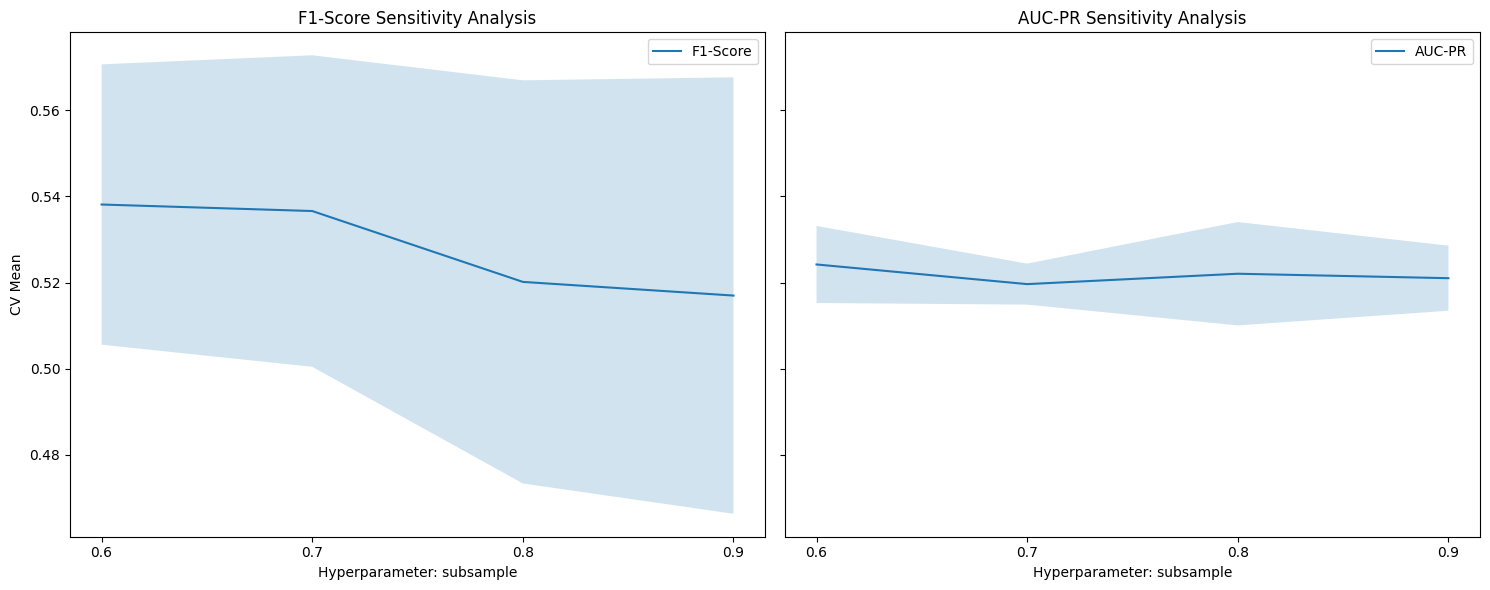

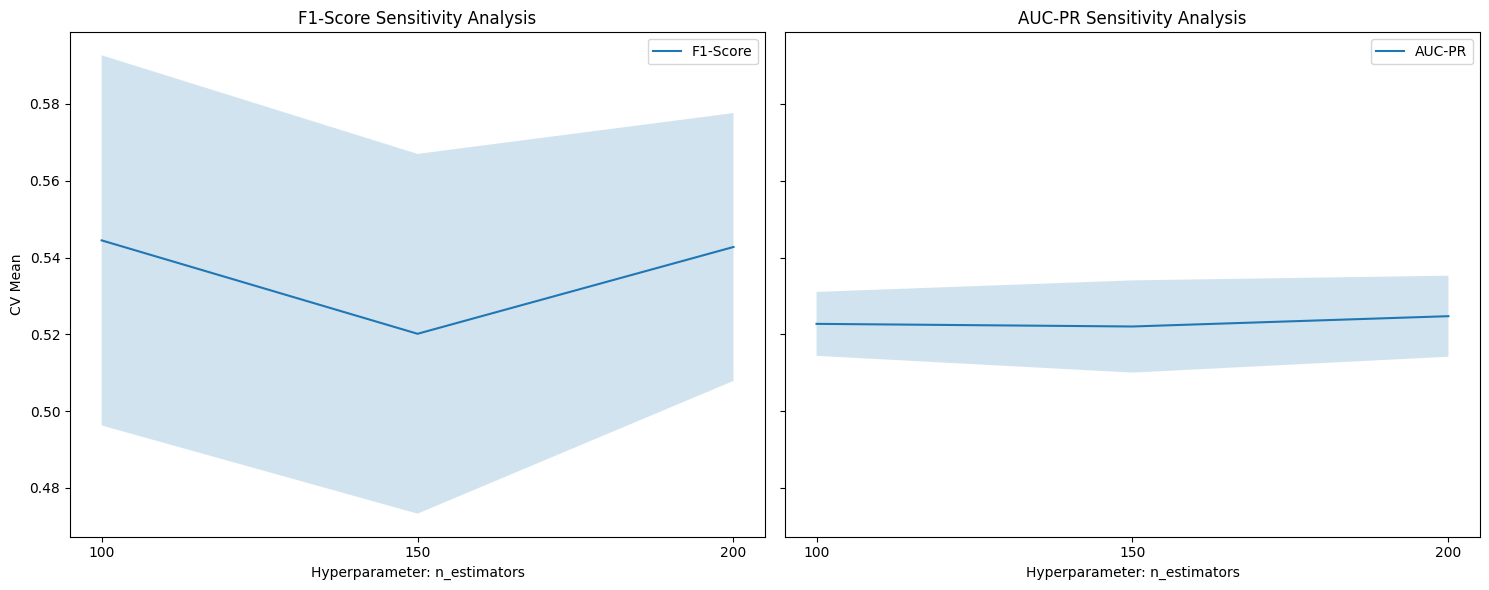

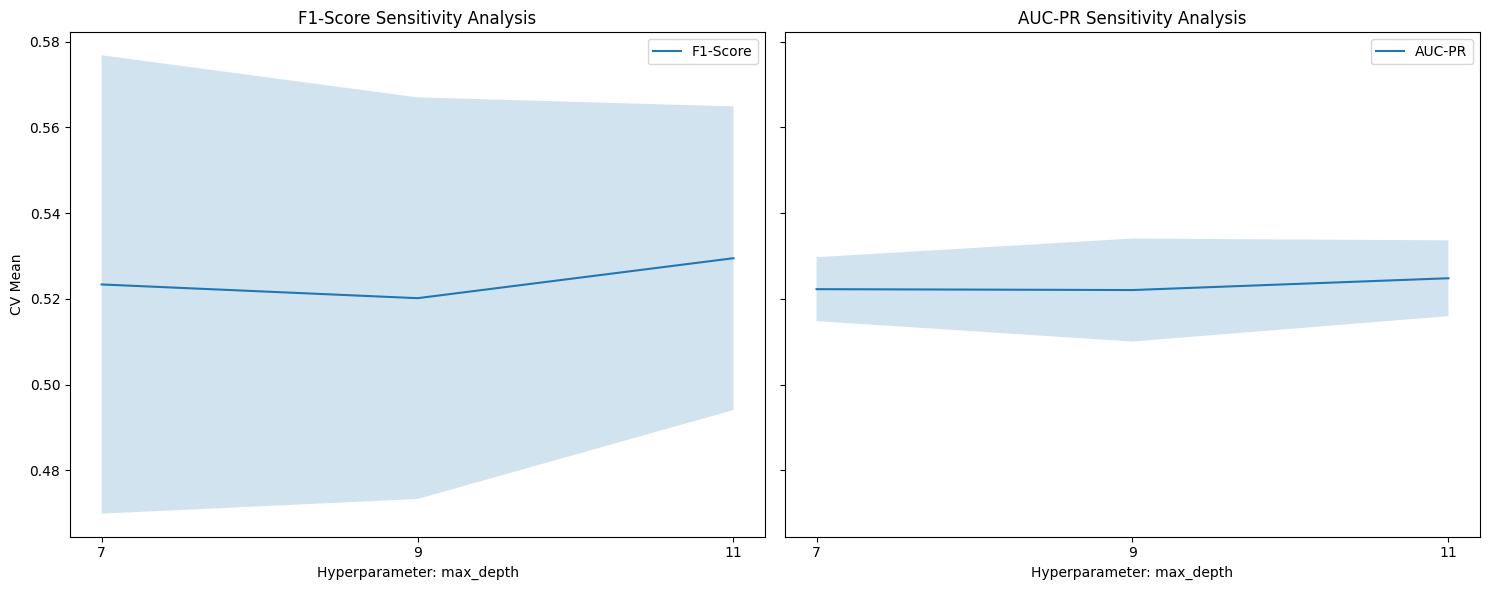

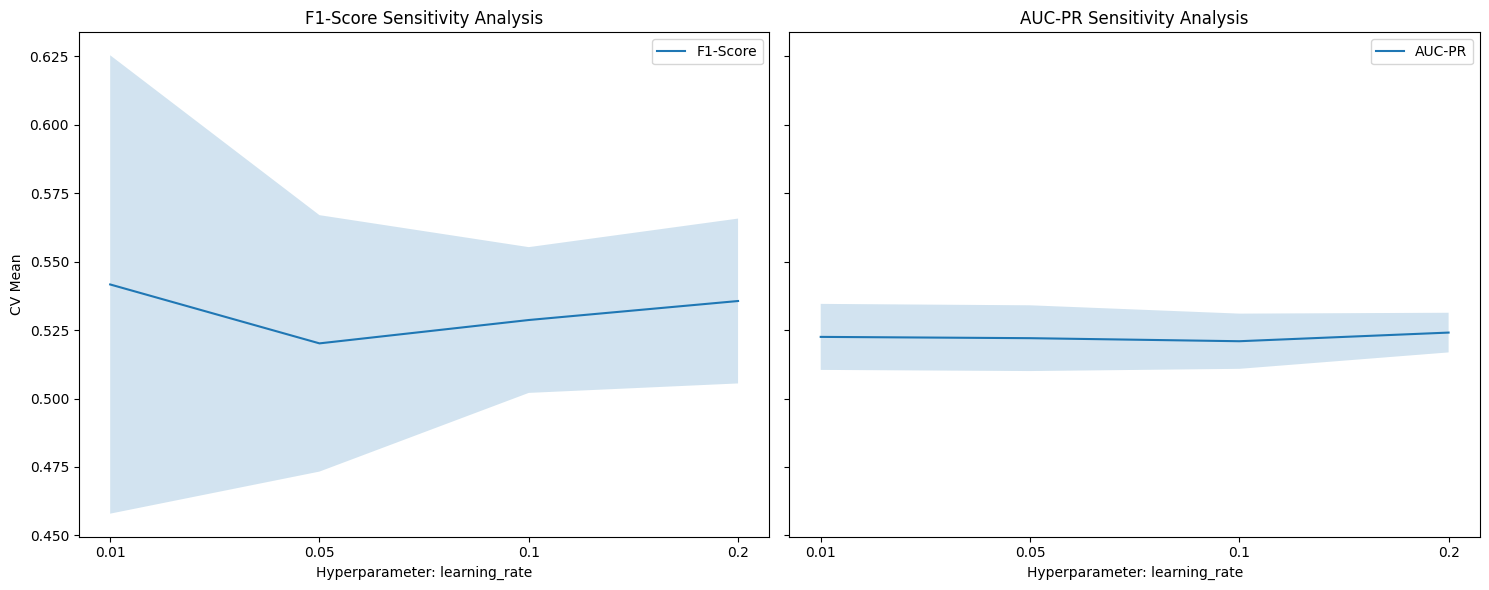

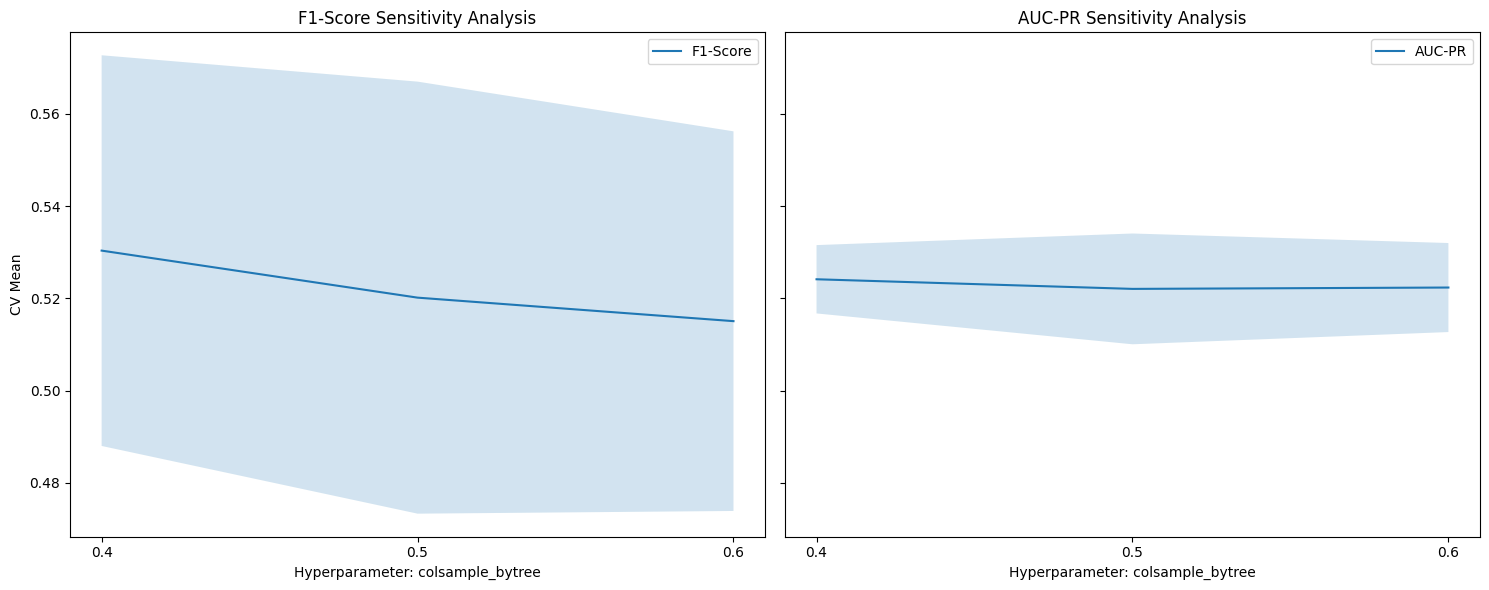

In [50]:
param_list = ['subsample', 'n_estimators', 'max_depth', 'learning_rate', 'colsample_bytree']
for param_filter in param_list:
  # Filter data for 'subsample' param
  param_data = sensitivity_df[sensitivity_df['param'] == param_filter]

  # Create separate DataFrames for F1-Score and AUC-PR
  f1_data = param_data[param_data['metric'] == 'F1-Score']
  auc_pr_data = param_data[param_data['metric'] == 'AUC-PR']

  # Set up the figure and axes
  fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

  # Plot F1-Score
  sns.lineplot(x='value', y='cv_mean', data=f1_data, label='F1-Score', errorbar='sd', ax=axes[0])
  axes[0].fill_between(f1_data['value'], f1_data['cv_mean'] - f1_data['cv_std'], f1_data['cv_mean'] + f1_data['cv_std'], alpha=0.2)

  # Set labels and title for F1-Score plot
  axes[0].set_xlabel(f'Hyperparameter: {param_filter}')
  axes[0].set_ylabel('CV Mean')
  axes[0].set_title('F1-Score Sensitivity Analysis')
  axes[0].legend()

  # Plot AUC-PR
  sns.lineplot(x='value', y='cv_mean', data=auc_pr_data, label='AUC-PR', errorbar='sd', ax=axes[1])
  axes[1].fill_between(auc_pr_data['value'], auc_pr_data['cv_mean'] - auc_pr_data['cv_std'], auc_pr_data['cv_mean'] + auc_pr_data['cv_std'], alpha=0.2)

  # Set labels and title for AUC-PR plot
  axes[1].set_xlabel(f'Hyperparameter: {param_filter}')
  axes[1].set_ylabel('CV Mean')
  axes[1].set_title('AUC-PR Sensitivity Analysis')
  axes[1].legend()

  # Adjust layout
  plt.tight_layout()

  # Show the plots
  plt.show()